# MNIST
The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students adn employees of the US Census Bureau. Each image is labeled by the digit it represents.

Scikit-Learn provides many helper functions to donwload popular datasets. MNIST is one of them.
### Fetching the Dataset

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

#By default Scikit-Learn caches download datasets in a directory called $HOME/scikit_learn_data

/home/amado/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column  per feature
- A target key containing an array with the labels

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images,, and each image has 784 features. This is because each image is 28 x 28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). 
### Showing an Image

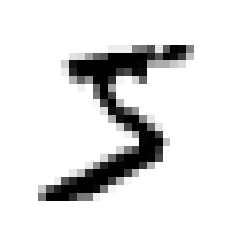

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0:1]
some_digit_image = np.reshape(some_digit.to_numpy(), (28, -1))

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

### Casting Label as Interger from String

In [5]:
y = y.astype(np.uint8)

### Split Test Set
The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images): The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (dont't want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training intances, and they perform poorly if they get many similar  instances in a row. Shuffling the dataset ensures that this won't happen.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
The binary classifier is capable of distinguishing between just to classes, 5 and not-5. Let's create the target vectors for this classification task:

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Stochastic Gradient Descent (SGD)
Now let's pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent classifier.
This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because deals with training intantances independently, on at a time (which also makes SGD well suited for online learning), as we will see later.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict(X[0:1])

array([ True])

## Performance Measures
### Measuring Accuracy Using Cross-Validation
Let's use the cross_val_score() function to evaluate our SGDClassifier model, using K-fold cross-validation with three folds. Remember that K-fold corss-validation means pslitting the training set into K folds, then mkaing predictions and evaluating them on each fold using a model trained on the remaining folds.

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

This may seem like good results at first sight but this is not an accurate way of measuring the accuracy of this algorithm. This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.
This demonstrates why accuracy is generally not the preffered performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent han others).

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. 

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but intead of returning the valuation scores, it returns the predictions made on each test fold.
Now you are ready to get the confusion matrix using the confusion_matrix() function. Just it the target classes (y_train_5) and the predited classes (y_train_pred):

In [12]:
from sklearn.metrics import confusion_matrix

"""
Each row in a confusion matrix represents an actual class:

[[True Negative, False Positive],
 [False Negative, True Positive]]
 
"""

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric.
### Precision && Recall Metrics

In [13]:
'''
Accuracy of the positive predictions; called the precision of the classifier:

        precision = TP / (TP + FP)

Precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR):
This is the ratio of positive instance that correctly detected by the classifier.

        recall = TP / (TP + FN)
        
'''

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [14]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and reclal. Whereas the regular mean treats all values equally , the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

In [15]:
'''
            F1 = TP / (TP + ((FN + FP) / 2))
'''

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors clasifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. FOr example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather rhan a classifier that has much higher recall but lets a few really bad videos show up in your products ( in such cases, you may evn want to add a himan pipeline to check the classifier's video selection). On the other hand, supoose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall ( sure, the security guards will get a few false alerts, but almost all shoplifters will get caught). Unfortunately, you can't habve it both ways: increasing precision reduces recal, and vice versa.
### Precision/Recall Trade-off
To understand this trade-off, let's look at how the SGD Classifier makes its classification decisions. For each instance, it computes a score based ona decision function. If that score is greater thana threshold, it assigns the instance to the possitive class; otherwise it assigns it to the negative class. Lowering threshold increases recall and reduces precision and vice versa.

Scikit-Learn does not let you set the threshold directly, but it does give you acces to the decision scores that it uses to make predictions. Instead of calling the clasifier's precit() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to mkae predictions besed on those scores:

In [16]:
y_scores = sgd_clf.decision_function(X[0:1])
y_scores

array([2164.22030239])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

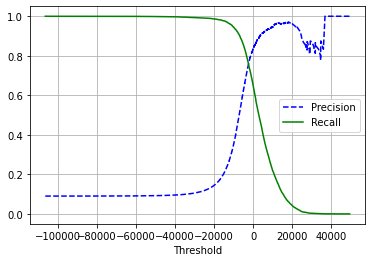

In [42]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    # highlight the threshold and add the legends, axis label, and grid
    plt.xlabel("Threshold")
    plt.legend()
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

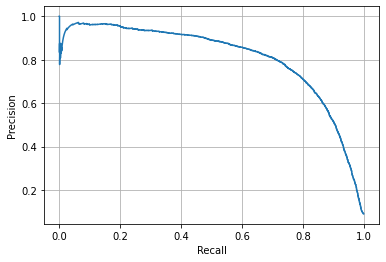

In [45]:
plt.plot(recalls[:-1], precisions[:-1])
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall trade-off just before that drop - for example, at around 60% recall. But of course, the choice depends on your projects.

Suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 8,000. To be more precise youc an search for the lowest threshold that gives you at least 90% precision (np.argmax() will give you the first index of the maximum value, which is the case mean the first True value):

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

To make predictions (on the training set now), intead of calling the classifiers predict() methods, you can run this code:

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let's check these predictions' precision and recall:

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve
The reciever operating characteristic curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, bu tintead of plotting precision versus recall, the ROC curve plots the tru positive rate ( anotehr name for recall) against the false possitive rate (FPR). The FPR is the ration of negative instances that are incorrectly classified as positive. It is equal to 1 - the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 - specificity.

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

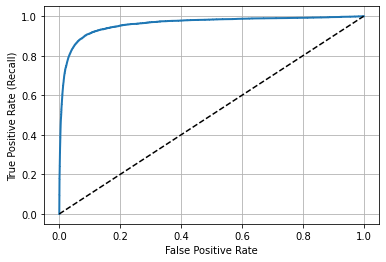

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") #Dashed Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

Once again thre is a trade-off : the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

### ROC AUC Score
One way to tocompare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to computer the ROC AUC:

In [50]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest Classifier
Let's now train a RandomForesClssifier and compare its ROC curve and ROC AUC score those of the SGDClassifier. First, you need to get the scores of each instance inthe training set. But due to teh way it works, the RandomForesClassifier class noes not have a decision_function() method. Intead, it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other, or both. The predict_proba(0 method returns an array containing a row per instance anda  column per class, each containing the probablity that the igven instance belogns ot the given class:

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

The roc_curve() functins expects labels and scores, but instead of scores you can give it class porbabilities. Let's use the positive class's probability as teh score:

In [56]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

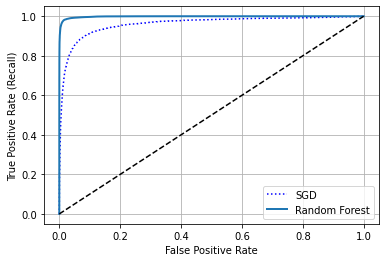

In [57]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

Comparing ROC curves: the Rand Forest Classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC.

In [58]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

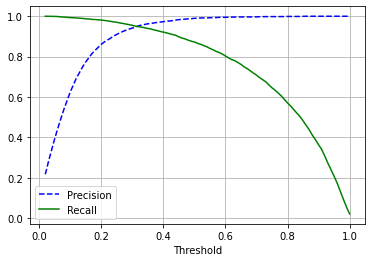

In [65]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)
plt.show()

In [67]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [68]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [69]:
f1_score(y_train_5, y_train_pred_forest)

0.9242275142688446

### Training Rand Forest Classifier on Entire Set

In [71]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

#### Scaling Inputs


In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.96445, 0.96255, 0.96645])